In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_predict
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline 
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import joblib
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_squared_error, mean_absolute_error, r2_score
import holidays
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]

# 1. Data Loading and Parsing

In [4]:
def load_data(filepath):
    """
    Loads data and handles multiple datetime formats
    Why: Ensures consistent datetime parsing regardless of input format
    Benefit: Prevents errors in subsequent time-based feature engineering
    """
    df = pd.read_csv(filepath)
    for fmt in ['%d-%m-%Y', '%Y-%m-%d', '%m/%d/%Y']:
        try:
            df['date'] = pd.to_datetime(df['date'], format=fmt)
            break
        except ValueError:
            continue
    return df

train_data = load_data('ds-ca-3-q-2/regression-dataset-train.csv')
test_data = load_data('ds-ca-3-q-2/regression-dataset-test-unlabeled.csv')

# 1.5 Data Visualization and Exploration

In [5]:
# 1. Basic Info
print("\nTraining Data Shape:", train_data.shape)
print("\nTraining Data Columns:")
print(train_data.columns.tolist())
print("\nTraining Data Info:")
print(train_data.info())


Training Data Shape: (510, 14)

Training Data Columns:
['id', 'date', 'season_id', 'year', 'month', 'is_holiday', 'weekday', 'is_workingday', 'weather_condition', 'temperature', 'feels_like_temp', 'humidity', 'wind_speed', 'total_users']

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 510 non-null    int64         
 1   date               510 non-null    datetime64[ns]
 2   season_id          510 non-null    int64         
 3   year               510 non-null    int64         
 4   month              510 non-null    int64         
 5   is_holiday         510 non-null    int64         
 6   weekday            510 non-null    int64         
 7   is_workingday      510 non-null    int64         
 8   weather_condition  510 non-null    int64         
 9   temperature        510 no

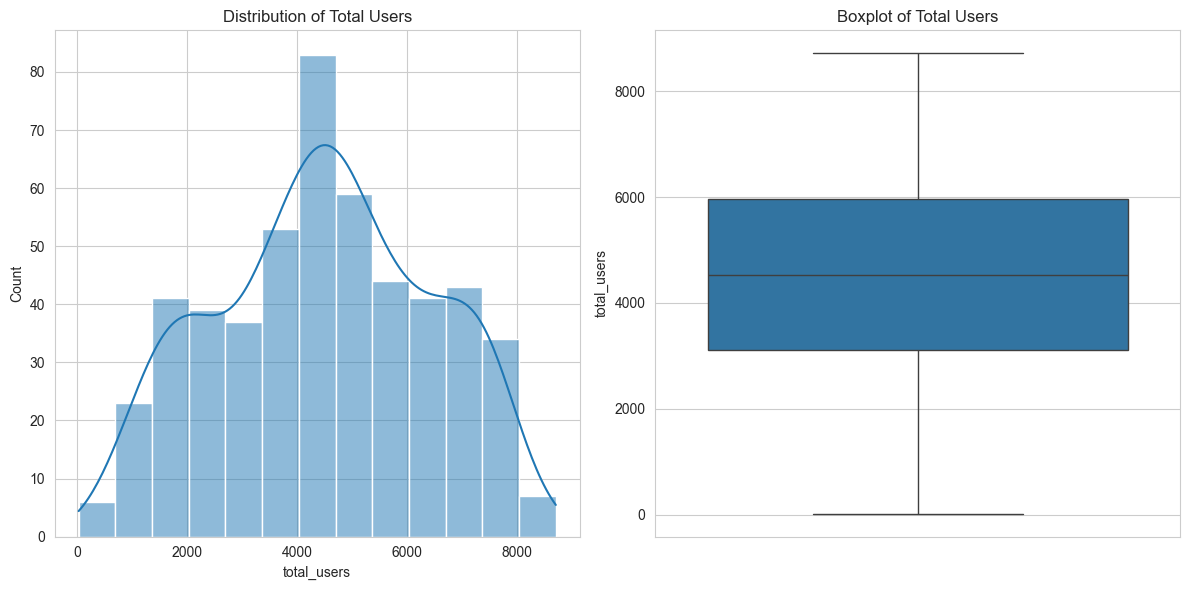

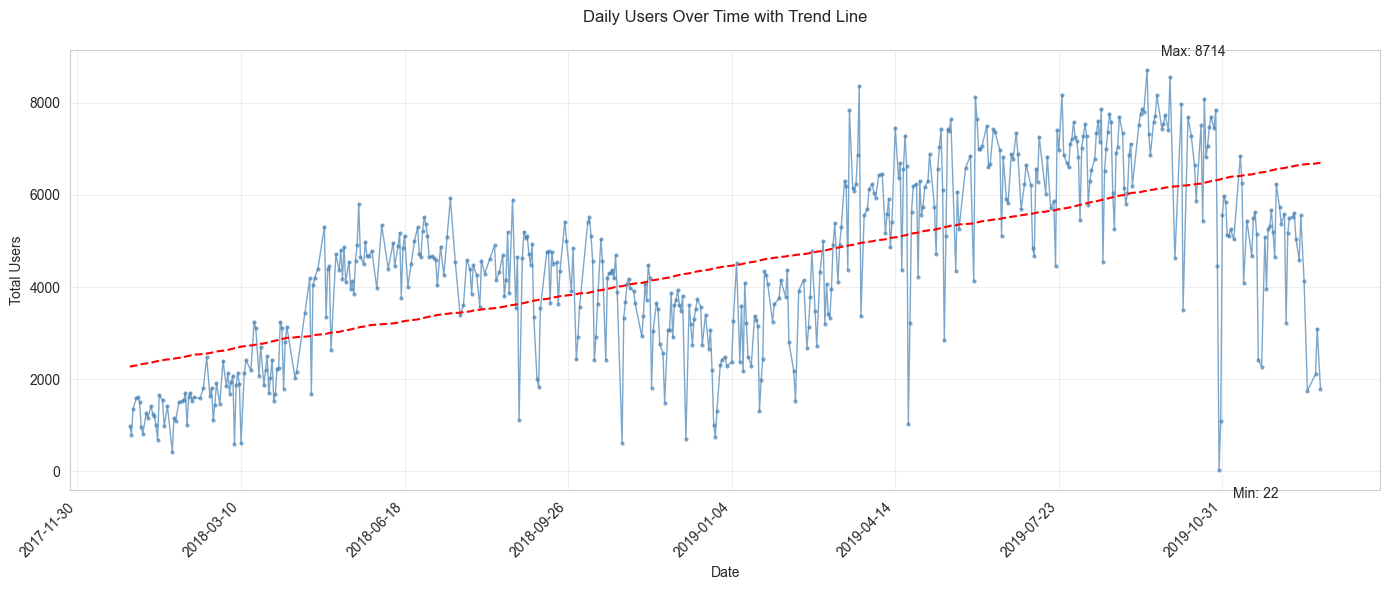

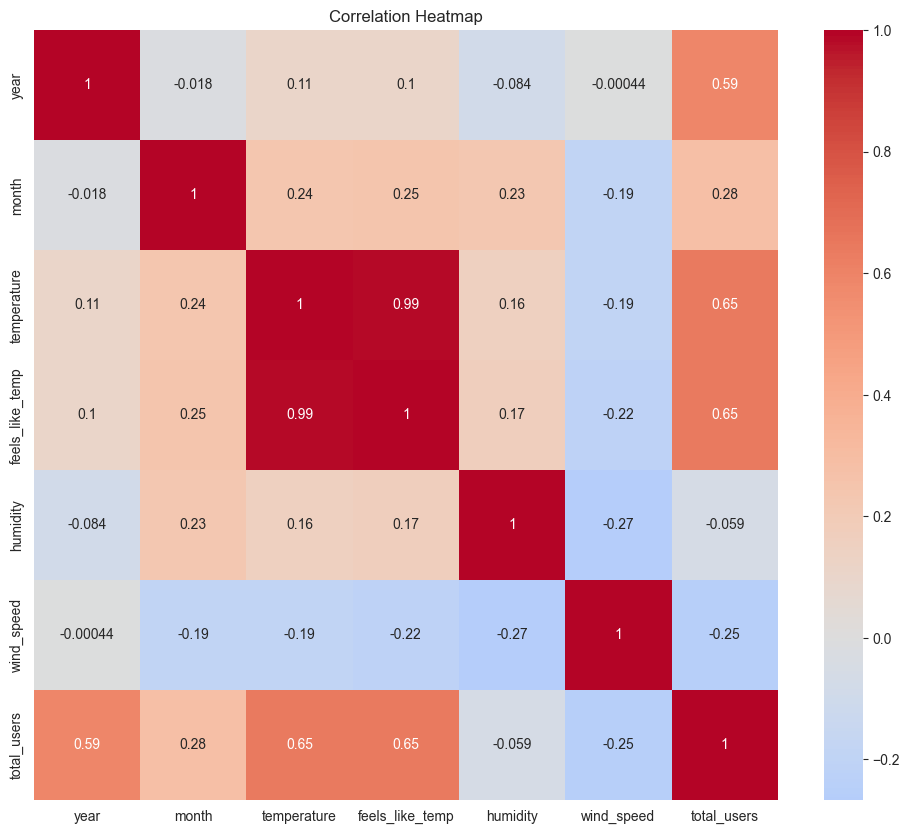

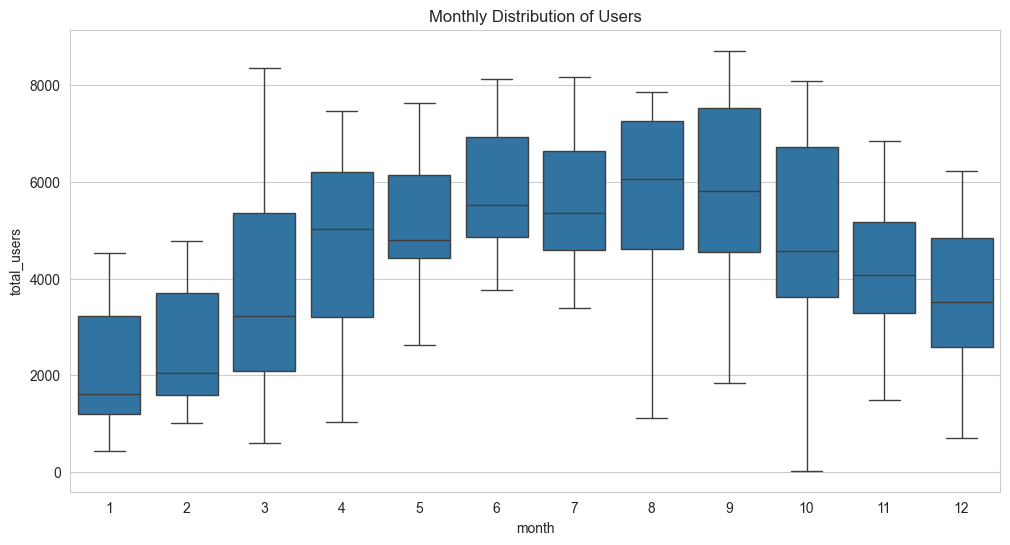

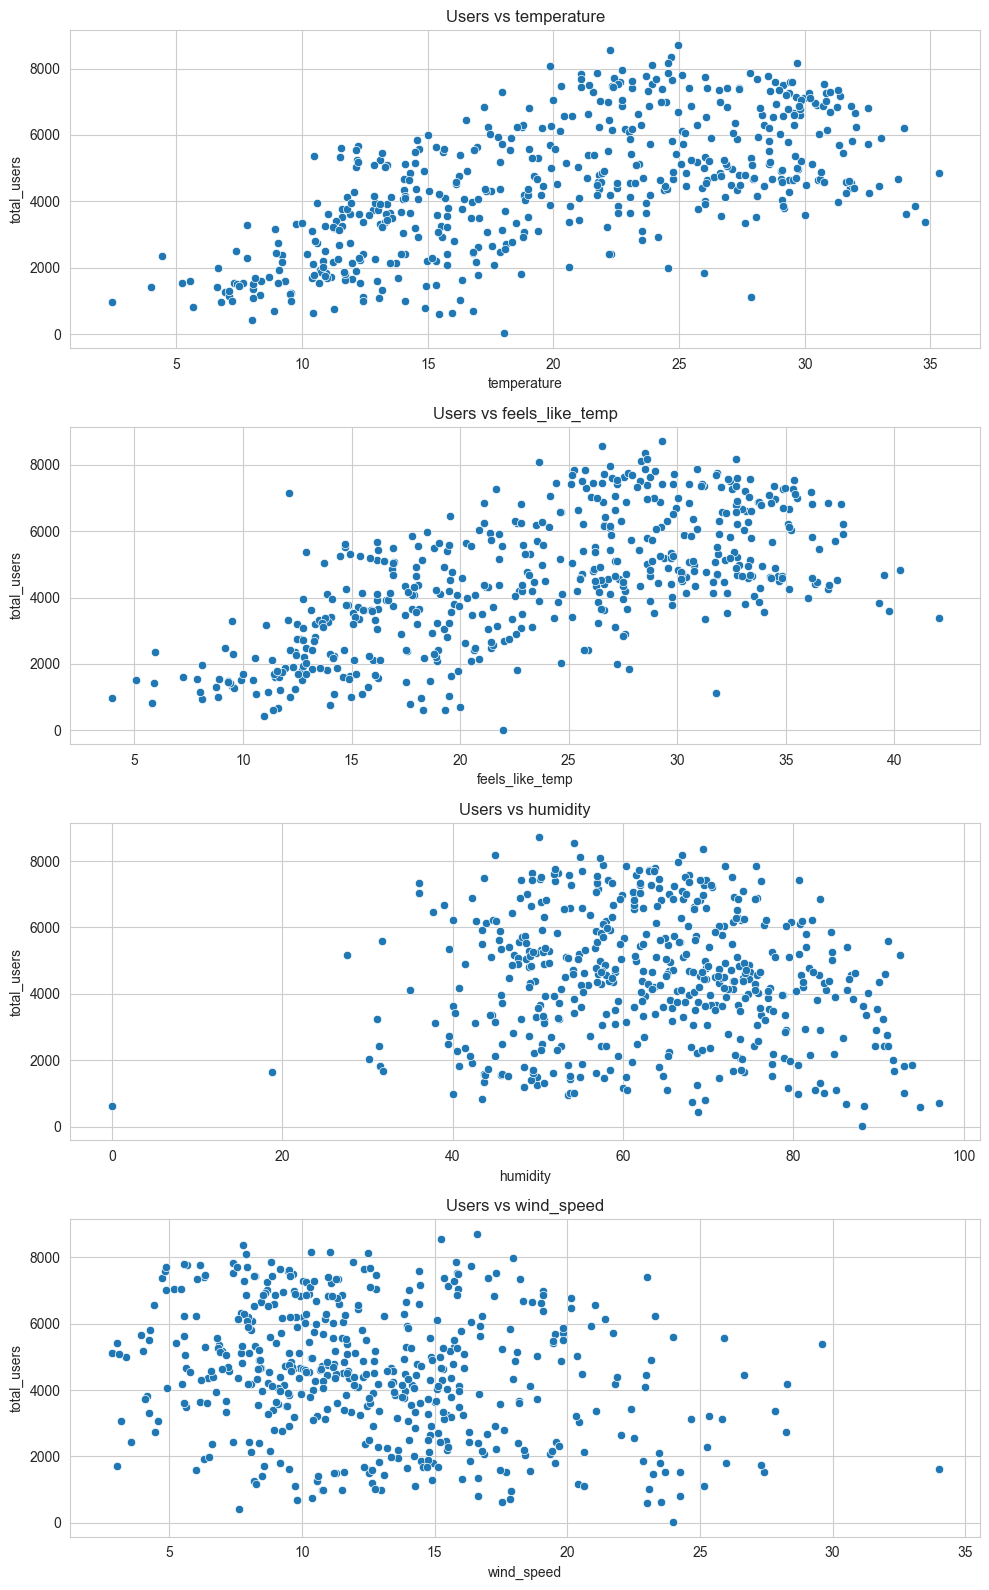

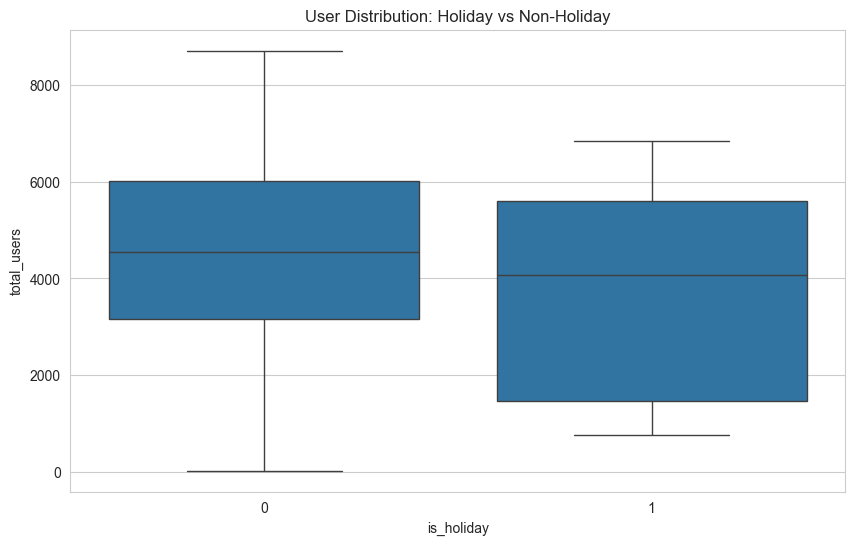

In [ ]:
# 2. Target Variable Distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(train_data['total_users'], kde=True)
plt.title('Distribution of Total Users')

plt.subplot(1, 2, 2)
sns.boxplot(y=train_data['total_users'])
plt.title('Boxplot of Total Users')
plt.tight_layout()
plt.show()

# 3. Time Series Plot of Target
if 'date' in train_data.columns:
    plt.figure(figsize=(14, 6))
    
    ts_data = train_data.set_index('date')['total_users']
    
    ax = ts_data.plot(
        style='-',
        color='steelblue',
        linewidth=1,
        marker='o',
        markersize=3,
        markeredgecolor='none',
        alpha=0.7
    )
    
    z = np.polyfit(range(len(ts_data.index)), ts_data.values, 1)
    p = np.poly1d(z)
    ax.plot(ts_data.index, p(range(len(ts_data.index))), "r--", linewidth=1.5)
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(10)) 
    plt.xticks(rotation=45)
    
    plt.grid(True, alpha=0.3)
    plt.title('Daily Users Over Time with Trend Line', pad=20)
    plt.ylabel('Total Users')
    plt.xlabel('Date')
    
    max_idx = ts_data.idxmax()
    min_idx = ts_data.idxmin()
    ax.annotate(f'Max: {ts_data.max():.0f}', xy=(max_idx, ts_data.max()), 
                xytext=(10, 10), textcoords='offset points',
                arrowprops=dict(arrowstyle="->"))
    ax.annotate(f'Min: {ts_data.min():.0f}', xy=(min_idx, ts_data.min()), 
                xytext=(10, -20), textcoords='offset points',
                arrowprops=dict(arrowstyle="->"))
    
    plt.tight_layout()
    plt.show()

# 4. Correlation Heatmap
numeric_features = ['year', 'month', 'temperature', 'feels_like_temp', 'humidity', 'wind_speed']
plt.figure(figsize=(12, 10))
corr = train_data[numeric_features + ['total_users']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

# 5. Seasonal Patterns
if 'date' in train_data.columns:
    train_data['month'] = train_data['date'].dt.month
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='month', y='total_users', data=train_data)
    plt.title('Monthly Distribution of Users')
    plt.show()

# 6. Weather Relationships
weather_cols = ['temperature', 'feels_like_temp', 'humidity', 'wind_speed']
weather_cols = [col for col in weather_cols if col in train_data.columns]
if weather_cols:
    fig, axes = plt.subplots(len(weather_cols), 1, figsize=(10, 4*len(weather_cols)))
    for i, col in enumerate(weather_cols):
        sns.scatterplot(x=col, y='total_users', data=train_data, ax=axes[i])
        axes[i].set_title(f'Users vs {col}')
    plt.tight_layout()
    plt.show()

# 7. Holiday Impact
if 'is_holiday' in train_data.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='is_holiday', y='total_users', data=train_data)
    plt.title('User Distribution: Holiday vs Non-Holiday')
    plt.show()

# 2. Advanced Feature Engineering

- Creates sophisticated features while handling edge cases
- Why: Better feature representation improves model performance
- Benefit: Captures complex temporal patterns and interactions

In [7]:
def create_features(df, target=None):
    df = df.copy()
    
    # A. DATETIME FEATURES
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
    
    temporal_features = {
        'day_of_week': lambda x: x.dt.dayofweek,
        'day_of_year': lambda x: x.dt.dayofyear,
        'week_of_year': lambda x: x.dt.isocalendar().week,
        'quarter': lambda x: x.dt.quarter,
        'is_weekend': lambda x: (x.dt.dayofweek >= 5).astype(int)
    }
    
    for name, func in temporal_features.items():
        try:
            df[name] = func(df['date'])
        except:
            df[name] = 0
    
    # B. CYCLICAL ENCODING
    # Why: Preserves cyclical nature of temporal features
    # Benefit: Helps model understand periodic patterns
    df['month_sin'] = np.sin(2 * np.pi * df['date'].dt.month/12)
    df['month_cos'] = np.cos(2 * np.pi * df['date'].dt.month/12)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)
    
    # C. HOLIDAY FEATURES
    # Why: Special days significantly impact bike usage
    # Benefit: Captures known demand fluctuations
    try:
        country_holidays = holidays.CountryHoliday('US')
        df['is_holiday'] = df['date'].dt.date.apply(lambda x: x in country_holidays).astype(int)
        holiday_dates = [pd.to_datetime(date) for date in country_holidays.keys()]
        df['days_to_holiday'] = df['date'].apply(
            lambda x: min(abs((x - h).days) for h in holiday_dates) if holiday_dates else 30
        )
    except:
        df['is_holiday'] = 0
        df['days_to_holiday'] = 30
    
    # D. WEATHER INTERACTIONS
    # Why: Non-linear weather effects on bike usage
    # Benefit: Captures complex weather-usage relationships
    weather_cols = ['temperature', 'feels_like_temp', 'humidity', 'wind_speed']
    for col in weather_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(df[col].median())
    
    if all(col in df.columns for col in ['temperature', 'humidity', 'wind_speed']):
        df['temp_squared'] = df['temperature'] ** 2
        df['humidity_squared'] = df['humidity'] ** 2
        df['temp_humidity'] = df['temperature'] * df['humidity']
        df['temp_wind_chill'] = 13.12 + 0.6215*df['temperature'] - 11.37*(df['wind_speed']**0.16) + 0.3965*df['temperature']*(df['wind_speed']**0.16)
    
    # E. ROLLING STATISTICS (TRAIN ONLY)
    # Why: Capture recent usage patterns
    # Benefit: Models short-term demand trends
    if target is not None: 
        df = df.sort_values('date')
        for window in [3, 7, 14]:
            df[f'rolling_mean_{window}'] = target.rolling(window).mean().shift(1)
            df[f'rolling_std_{window}'] = target.rolling(window).std().shift(1)
        df.fillna(method='bfill', inplace=True)
    
    # F. FOURIER FEATURES
    # Why: Model seasonal patterns at different frequencies
    # Benefit: Captures yearly seasonality more effectively
    day_of_year = df['date'].dt.dayofyear if pd.api.types.is_datetime64_any_dtype(df['date']) else 0
    for k in range(1, 3):
        df[f'fourier_sin_{k}'] = np.sin(2 * np.pi * k * day_of_year/365.25)
        df[f'fourier_cos_{k}'] = np.cos(2 * np.pi * k * day_of_year/365.25)
    
    return df

train_data = create_features(train_data, train_data['total_users'])
test_data = create_features(test_data)

# 3. Feature Selection

In [8]:
rolling_features = [f'rolling_mean_{w}' for w in [3,7,14]] + [f'rolling_std_{w}' for w in [3,7,14]]
X = train_data.drop(['id', 'date', 'total_users'] + rolling_features, axis=1, errors='ignore')
y = train_data['total_users']

X = X.loc[:, X.nunique() > 1]

# 4. Model Training and Tuning

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [200, 300, 400], 
    'max_depth': [None, 15, 20, 25], 
    'min_samples_split': [2, 5, 10], 
    'max_features': ['sqrt', 'log2', 0.5],
    'bootstrap': [True, False]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(rf, param_grid, cv=5, 
                          scoring='neg_mean_squared_error', 
                          n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 15, 20, 25],
                         'max_features': ['sqrt', 'log2', 0.5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [200, 300, 400]},
             scoring='neg_mean_squared_error', verbose=1)

# 5. Model Evaluation

In [10]:
best_params = grid_search.best_params_
print(f"\nBest Parameters: {best_params}")

best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)

val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_mae = mean_absolute_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print("\nValidation Set Performance:")
print(f"RMSE: {val_rmse:.2f}")
print(f"MAE: {val_mae:.2f}")
print(f"R2 Score: {val_r2:.4f}")


Best Parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 0.5, 'min_samples_split': 2, 'n_estimators': 400}

Validation Set Performance:
RMSE: 671.06
MAE: 504.83
R2 Score: 0.8819


# 6. Final Model Training

In [11]:
final_model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
final_model.fit(X, y)

cv_rmse_scores = np.sqrt(-cross_val_score(
    final_model, 
    X, y,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
))

print("\nFinal Model Performance on Full Data:")
print("Cross-validated RMSE scores:", cv_rmse_scores)
print(f"Mean CV RMSE: {cv_rmse_scores.mean():.2f} (±{cv_rmse_scores.std():.2f})")


Final Model Performance on Full Data:
Cross-validated RMSE scores: [1340.02362743  941.82593134  840.46946665 1061.47407483 1461.61847013]
Mean CV RMSE: 1129.08 (±235.80)


# 7. Feature Importance

In [12]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': final_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 20 Features:")
print(feature_importance.head(20))


Top 20 Features:
              Feature  Importance
1                year    0.242564
24    temp_wind_chill    0.229383
7         temperature    0.100007
21       temp_squared    0.085639
8     feels_like_temp    0.073329
22   humidity_squared    0.031872
9            humidity    0.031621
25      fourier_sin_1    0.024542
12        day_of_year    0.022105
27      fourier_sin_2    0.021020
10         wind_speed    0.018769
0           season_id    0.017792
6   weather_condition    0.015311
23      temp_humidity    0.014667
13       week_of_year    0.013303
26      fourier_cos_1    0.010877
20    days_to_holiday    0.009092
28      fourier_cos_2    0.007144
11        day_of_week    0.005224
4             weekday    0.004788


# 8. Prediction and Submission

In [ ]:
X_test = test_data[X.columns].copy()

for col in X.columns:
    if col not in X_test.columns:
        X_test[col] = 0 

test_pred = final_model.predict(X_test)

submission = pd.DataFrame({
    'id': test_data['id'],
    'label': test_pred
})
submission.to_csv('optimized_rf_submission_2.csv', index=False)

# Other models that were uploaded in kaggle

## 1. optimized_rf_submission_enhanced.csv

In [ ]:
# ----------------------------
# 1. DATA LOADING AND PARSING
# ----------------------------
def load_data(filepath):
    """
    Loads data and handles multiple datetime formats
    Why: Ensures consistent datetime parsing regardless of input format
    Benefit: Prevents errors in subsequent time-based feature engineering
    """
    df = pd.read_csv(filepath)
    for fmt in ['%d-%m-%Y', '%Y-%m-%d', '%m/%d/%Y']:
        try:
            df['date'] = pd.to_datetime(df['date'], format=fmt)
            break
        except ValueError:
            continue
    return df

train_data = load_data('regression-dataset-train.csv')
test_data = load_data('regression-dataset-test-unlabeled.csv')

# ----------------------------
# 2. ADVANCED FEATURE ENGINEERING
# ----------------------------
def create_features(df, target=None):
    """
    Creates sophisticated features while handling edge cases
    Why: Better feature representation improves model performance
    Benefit: Captures complex temporal patterns and interactions
    """
    df = df.copy()
    
    # A. DATETIME FEATURES
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
    
    temporal_features = {
        'day_of_week': lambda x: x.dt.dayofweek,
        'day_of_year': lambda x: x.dt.dayofyear,
        'week_of_year': lambda x: x.dt.isocalendar().week,
        'quarter': lambda x: x.dt.quarter,
        'is_weekend': lambda x: (x.dt.dayofweek >= 5).astype(int)
    }
    
    for name, func in temporal_features.items():
        try:
            df[name] = func(df['date'])
        except:
            df[name] = 0  # Fallback value
    
    # B. CYCLICAL ENCODING
    # Why: Preserves cyclical nature of temporal features
    # Benefit: Helps model understand periodic patterns
    df['month_sin'] = np.sin(2 * np.pi * df['date'].dt.month/12)
    df['month_cos'] = np.cos(2 * np.pi * df['date'].dt.month/12)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)
    
    # C. HOLIDAY FEATURES
    # Why: Special days significantly impact bike usage
    # Benefit: Captures known demand fluctuations
    try:
        country_holidays = holidays.CountryHoliday('US')
        df['is_holiday'] = df['date'].dt.date.apply(lambda x: x in country_holidays).astype(int)
        holiday_dates = [pd.to_datetime(date) for date in country_holidays.keys()]
        df['days_to_holiday'] = df['date'].apply(
            lambda x: min(abs((x - h).days) for h in holiday_dates) if holiday_dates else 30
        )
    except:
        df['is_holiday'] = 0
        df['days_to_holiday'] = 30
    
    # D. WEATHER INTERACTIONS
    # Why: Non-linear weather effects on bike usage
    # Benefit: Captures complex weather-usage relationships
    weather_cols = ['temperature', 'feels_like_temp', 'humidity', 'wind_speed']
    for col in weather_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(df[col].median())
    
    if all(col in df.columns for col in ['temperature', 'humidity', 'wind_speed']):
        df['temp_squared'] = df['temperature'] ** 2
        df['humidity_squared'] = df['humidity'] ** 2
        df['temp_humidity'] = df['temperature'] * df['humidity']
        df['temp_wind_chill'] = 13.12 + 0.6215*df['temperature'] - 11.37*(df['wind_speed']**0.16) + 0.3965*df['temperature']*(df['wind_speed']**0.16)
    
    # E. ROLLING STATISTICS (TRAIN ONLY)
    # Why: Capture recent usage patterns
    # Benefit: Models short-term demand trends
    if target is not None:
        df = df.sort_values('date')
        for window in [3, 7, 14]:
            df[f'rolling_mean_{window}'] = target.rolling(window).mean().shift(1)
            df[f'rolling_std_{window}'] = target.rolling(window).std().shift(1)
        df.fillna(method='bfill', inplace=True)
    
    # F. FOURIER FEATURES
    # Why: Model seasonal patterns at different frequencies
    # Benefit: Captures yearly seasonality more effectively
    day_of_year = df['date'].dt.dayofyear if pd.api.types.is_datetime64_any_dtype(df['date']) else 0
    for k in range(1, 3):  # Multiple harmonics
        df[f'fourier_sin_{k}'] = np.sin(2 * np.pi * k * day_of_year/365.25)
        df[f'fourier_cos_{k}'] = np.cos(2 * np.pi * k * day_of_year/365.25)
    
    return df

train_data = create_features(train_data, train_data['total_users'])
test_data = create_features(test_data)  # No target for test data

# ----------------------------
# 3. FEATURE SELECTION WITH P-VALUES
# ----------------------------
rolling_features = [f'rolling_mean_{w}' for w in [3,7,14]] + [f'rolling_std_{w}' for w in [3,7,14]]
X = train_data.drop(['id', 'date', 'total_users'] + rolling_features, axis=1, errors='ignore')
y = train_data['total_users']

X = X.loc[:, X.nunique() > 1]

print("\nInitial feature types:")
print(X.dtypes)

for col in X.columns:
    if pd.api.types.is_numeric_dtype(X[col]):
        continue

    try:
        X[col] = pd.to_numeric(X[col])
        print(f"Converted {col} to numeric")
    except ValueError:
        unique_values = X[col].nunique()
        if unique_values < 20:
            print(f"Treating {col} as categorical with {unique_values} unique values")
        else:
            print(f"Dropping {col} - too many unique values for categorical ({unique_values})")
            X = X.drop(col, axis=1)

categorical_features = [col for col in X.columns 
                       if not pd.api.types.is_numeric_dtype(X[col]) 
                       and X[col].nunique() < 20]

if categorical_features:
    print(f"\nOne-hot encoding categorical features: {categorical_features}")
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoded_data = encoder.fit_transform(X[categorical_features])
    encoded_cols = encoder.get_feature_names_out(categorical_features)
    X_encoded = pd.concat([
        X.drop(categorical_features, axis=1),
        pd.DataFrame(encoded_data, columns=encoded_cols)
    ], axis=1)
else:
    X_encoded = X.copy()

non_numeric = X_encoded.select_dtypes(exclude=['number']).columns
if len(non_numeric) > 0:
    print(f"\nWarning: Could not convert these features to numeric: {list(non_numeric)}")
    print("Dropping these features before OLS regression")
    X_encoded = X_encoded.select_dtypes(include=['number'])

print("\nChecking for missing/infinite values:")
print(X_encoded.isna().sum())
X_encoded = X_encoded.replace([np.inf, -np.inf], np.nan)
X_encoded = X_encoded.fillna(X_encoded.median())

for col in X_encoded.select_dtypes(include=['uint', 'UInt32', 'int32']).columns:
    X_encoded[col] = X_encoded[col].astype('int64')

for col in X_encoded.select_dtypes(include=['float32']).columns:
    X_encoded[col] = X_encoded[col].astype('float64')

try:
    X_encoded = sm.add_constant(X_encoded)
    print("\nFinal features for OLS regression:")
    print(X_encoded.dtypes)
    
    # Fit OLS model for p-value analysis
    print("\nRunning OLS regression...")
    ols_model = sm.OLS(y, X_encoded).fit()
    
    # Get significant features (p-value < 0.1)
    significant_features = ols_model.pvalues[ols_model.pvalues < 0.1].index.tolist()
    if 'const' in significant_features:
        significant_features.remove('const')

    original_features = []
    for feat in significant_features:
        is_encoded = any(feat.startswith(cat) for cat in categorical_features)
        if is_encoded:
            for cat in categorical_features:
                if feat.startswith(cat):
                    if cat not in original_features:
                        original_features.append(cat)
                    break
        else:
            if feat not in original_features:
                original_features.append(feat)

    print(f"\nSelected {len(original_features)} significant features based on p-values:")
    print(original_features)

    # Filter features based on p-value selection
    X = X[original_features]

except Exception as e:
    print(f"\nError in OLS regression: {str(e)}")
    print("\nDebugging information:")
    print(f"Shape of X_encoded: {X_encoded.shape}")
    print(f"NaN values: {X_encoded.isna().sum().sum()}")
    print(f"Infinite values: {np.isinf(X_encoded).sum().sum()}")
    print("\nFirst 5 rows of data:")
    print(X_encoded.head())
    
    print("\nProceeding with all numeric features")
    X = X.select_dtypes(include=['number'])
    if len(X.columns) == 0:
        print("No numeric features remaining! Using all original features")
        X = train_data.drop(['id', 'date', 'total_users'] + rolling_features, axis=1, errors='ignore')
        X = X.select_dtypes(include=['number'])

    
# ----------------------------
# 4. MODEL TRAINING AND TUNING
# ----------------------------
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [None, 15, 20, 25], 
    'min_samples_split': [2, 5, 10], 
    'max_features': ['sqrt', 'log2', 0.5],
    'bootstrap': [True, False] 
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(rf, param_grid, cv=5, 
                          scoring='neg_mean_squared_error', 
                          n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# ----------------------------
# 5. MODEL EVALUATION
# ----------------------------
best_params = grid_search.best_params_
print(f"\nBest Parameters: {best_params}")

best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)

val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_mae = mean_absolute_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print("\nValidation Set Performance:")
print(f"RMSE: {val_rmse:.2f}")
print(f"MAE: {val_mae:.2f}")
print(f"R2 Score: {val_r2:.4f}")

# ----------------------------
# 6. FINAL MODEL TRAINING
# ----------------------------
final_model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
final_model.fit(X, y) 

cv_rmse_scores = np.sqrt(-cross_val_score(final_model, X, y, 
                                        cv=5, 
                                        scoring='neg_mean_squared_error',
                                        n_jobs=-1))

print("\nCross-validated RMSE scores:", cv_rmse_scores)
print(f"Mean CV RMSE: {cv_rmse_scores.mean():.2f} (±{cv_rmse_scores.std():.2f})")

# ----------------------------
# 7. FEATURE IMPORTANCE
# ----------------------------
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': final_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 20 Features:")
print(feature_importance.head(20))

# ----------------------------
# 8. PREDICTION AND SUBMISSION
# ----------------------------

X_test = test_data[X.columns].copy()

for col in X.columns:
    if col not in X_test.columns:
        X_test[col] = 0  

test_pred = final_model.predict(X_test)

submission = pd.DataFrame({
    'id': test_data['id'],
    'label': test_pred
})
submission.to_csv('optimized_rf_submission_enhanced.csv', index=False)
print("\nSubmission file created!")


Initial feature types:
season_id              int64
year                   int64
month                  int64
is_holiday             int64
weekday                int64
is_workingday          int64
weather_condition      int64
temperature          float64
feels_like_temp      float64
humidity             float64
wind_speed           float64
day_of_week            int32
day_of_year            int32
week_of_year          UInt32
quarter                int32
is_weekend             int64
month_sin            float64
month_cos            float64
day_sin              float64
day_cos              float64
days_to_holiday        int64
temp_squared         float64
humidity_squared     float64
temp_humidity        float64
temp_wind_chill      float64
fourier_sin_1        float64
fourier_cos_1        float64
fourier_sin_2        float64
fourier_cos_2        float64
dtype: object

Checking for missing/infinite values:
season_id            0
year                 0
month                0
is_holiday   

## 2. optimized_rf_submission

In [85]:
def load_data(filepath):
    df = pd.read_csv(filepath)
    for fmt in ['%d-%m-%Y', '%Y-%m-%d', '%m/%d/%Y']:
        try:
            df['date'] = pd.to_datetime(df['date'], format=fmt)
            break
        except ValueError:
            continue
    return df

train_data = load_data('regression-dataset-train.csv')
test_data = load_data('regression-dataset-test-unlabeled.csv')

def create_features(df, target=None):
    df = df.copy()

    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'], errors='coerce')

    try:
        df['day_of_week'] = df['date'].dt.dayofweek
        df['day_of_year'] = df['date'].dt.dayofyear
        df['week_of_year'] = df['date'].dt.isocalendar().week
        df['quarter'] = df['date'].dt.quarter
        df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    except AttributeError:
        df['day_of_week'] = 0
        df['day_of_year'] = 0
        df['week_of_year'] = 0
        df['quarter'] = 0
        df['is_weekend'] = 0

    df['month_sin'] = np.sin(2 * np.pi * df['date'].dt.month/12)
    df['month_cos'] = np.cos(2 * np.pi * df['date'].dt.month/12)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)

    try:
        country_holidays = holidays.CountryHoliday('US')
        df['is_holiday'] = df['date'].dt.date.apply(lambda x: x in country_holidays).astype(int)
        holiday_dates = [pd.to_datetime(date) for date in country_holidays.keys()]
        df['days_to_holiday'] = df['date'].apply(
            lambda x: min(abs((x - h).days) for h in holiday_dates) if len(holiday_dates) > 0 else 30
        )
    except:
        df['is_holiday'] = 0
        df['days_to_holiday'] = 30

    weather_cols = ['temperature', 'feels_like_temp', 'humidity', 'wind_speed']
    for col in weather_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col].fillna(df[col].median(), inplace=True)
    
    if all(col in df.columns for col in ['temperature', 'humidity', 'wind_speed']):
        df['temp_squared'] = df['temperature'] ** 2
        df['humidity_squared'] = df['humidity'] ** 2
        df['temp_humidity'] = df['temperature'] * df['humidity']
        df['temp_wind_chill'] = 13.12 + 0.6215*df['temperature'] - 11.37*(df['wind_speed']**0.16) + 0.3965*df['temperature']*(df['wind_speed']**0.16)

    if target is not None: 
        df = df.sort_values('date')
        for window in [3, 7, 14]:
            df[f'rolling_mean_{window}'] = target.rolling(window).mean().shift(1)
            df[f'rolling_std_{window}'] = target.rolling(window).std().shift(1)
        df.fillna(method='bfill', inplace=True)
    else: 
        for window in [3, 7, 14]:
            df[f'rolling_mean_{window}'] = np.nan
            df[f'rolling_std_{window}'] = np.nan

    day_of_year = df['date'].dt.dayofyear if pd.api.types.is_datetime64_any_dtype(df['date']) else 0
    for k in range(1, 3):
        df[f'fourier_sin_{k}'] = np.sin(2 * np.pi * k * day_of_year/365.25)
        df[f'fourier_cos_{k}'] = np.cos(2 * np.pi * k * day_of_year/365.25)
    
    return df

train_data = create_features(train_data, train_data['total_users'])
test_data = create_features(test_data)

X = train_data.drop(['id', 'date', 'total_users'], axis=1, errors='ignore')
y = train_data['total_users']

rolling_features = [f'rolling_mean_{w}' for w in [3,7,14]] + [f'rolling_std_{w}' for w in [3,7,14]]
X_test = test_data[X.columns].drop(columns=rolling_features, errors='ignore')

numeric_features = X.select_dtypes(include=np.number).columns
X = X.loc[:, X.nunique() > 1]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [None, 15, 20, 25],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', 0.5],
    'bootstrap': [True, False]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

y_pred = best_rf.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print(f"Validation MSE: {mse:.2f}")

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 20 Features:")
print(feature_importance.head(20))

X_test = test_data[X.columns].copy()
test_pred = best_rf.predict(X_test)
submission = pd.DataFrame({
    'id': test_data['id'],
    'label': test_pred
})
submission.to_csv('optimized_rf_submission.csv', index=False)

Best Parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 0.5, 'min_samples_split': 2, 'n_estimators': 300}
Validation MSE: 482950.01

Top 20 Features:
              Feature  Importance
24    temp_wind_chill    0.213864
1                year    0.207976
8     feels_like_temp    0.110637
21       temp_squared    0.097861
7         temperature    0.093854
9            humidity    0.034573
22   humidity_squared    0.032608
31      fourier_sin_1    0.022003
10         wind_speed    0.017183
33      fourier_sin_2    0.016376
12        day_of_year    0.015972
0           season_id    0.014060
6   weather_condition    0.013164
23      temp_humidity    0.012129
26      rolling_std_3    0.011482
13       week_of_year    0.010580
32      fourier_cos_1    0.008892
20    days_to_holiday    0.008850
28      rolling_std_7    0.005919
34      fourier_cos_2    0.005877
